# MovieLense

## Imports

In [79]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Get data

In [50]:
movie_info = tfds.load('movielens/100k-movies', split='all')

In [51]:
movie_ratings = tfds.load('movielens/100k-ratings', split='all')

In [52]:
movie_info_df = tfds.as_dataframe(movie_info)

In [53]:
movie_ratings_df = tfds.as_dataframe(movie_ratings)

## EDA

In [54]:
movie_info_df.head()

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


In [55]:
movie_info_df.describe()

,movie_genres,movie_id,movie_title
count,1682,1682,1682
unique,868,1682,1664
top,[7],b'1681',"b""Ulee's Gold (1997)"""
freq,376,1,2


In [56]:
movie_info_df.dtypes

,0
movie_genres,object
movie_id,object
movie_title,object


In [57]:
movie_ratings_df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [58]:
movie_ratings_df.describe()

,bucketized_user_age,raw_user_age,timestamp,user_occupation_label,user_rating
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,29.235460,32.969849,8.835289e+08,11.404320,3.529860
std,12.003675,11.562675,5.343856e+06,6.549283,1.125751
min,1.000000,7.000000,8.747247e+08,0.000000,1.000000
25%,18.000000,24.000000,8.794487e+08,6.000000,3.000000
50%,25.000000,30.000000,8.828269e+08,12.000000,4.000000
75%,35.000000,40.000000,8.882600e+08,17.000000,4.000000
max,56.000000,73.000000,8.932866e+08,21.000000,5.000000


In [59]:
movie_ratings_df.dtypes


,0
bucketized_user_age,float32
movie_genres,object
movie_id,object
movie_title,object
raw_user_age,float32
timestamp,int64
user_gender,bool
user_id,object
user_occupation_label,int64
user_occupation_text,object


### Prepreprocess

In [60]:
movie_info_df['movie_id'] = movie_info_df['movie_id'].apply(lambda x: x.decode("utf-8"))

In [61]:
movie_info_df['movie_title'] = movie_info_df['movie_title'].apply(lambda x: x.decode("utf-8"))

In [62]:
for col in movie_ratings_df.columns:
    if movie_ratings_df[col].dtype == 'object':
        movie_ratings_df[col] = movie_ratings_df[col].apply(
            lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
        )

In [63]:
movie_ratings_df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],357,One Flew Over the Cuckoo's Nest (1975),46.0,879024327,True,138,4,doctor,4.0,53211
1,25.0,"[4, 14]",709,Strictly Ballroom (1992),32.0,875654590,True,92,5,entertainment,2.0,80525
2,18.0,[4],412,"Very Brady Sequel, A (1996)",24.0,882075110,True,301,17,student,4.0,55439
3,50.0,"[5, 7]",56,Pulp Fiction (1994),50.0,883326919,True,60,4,healthcare,4.0,06472
4,50.0,"[10, 16]",895,Scream 2 (1997),55.0,891409199,True,197,18,technician,3.0,75094


#### Genre id to text

In [64]:
genres = ['Action' ,'Adventure' ,'Animation',
          'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy',
          'Film-Noir' ,'Horror' ,'IMAX' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi',
          'Thriller' ,'War' ,'Western', 'unknown']

In [65]:
def genre_id_to_text(genre_ids):
    return [genres[id] for id in genre_ids]

In [66]:
movie_ratings_df['genres_id'] = movie_ratings_df['movie_genres']

In [67]:
movie_ratings_df['movie_genres'] = movie_ratings_df['movie_genres'].apply(genre_id_to_text)

In [68]:
movie_ratings_df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,genres_id
0,45.0,[Drama],357,One Flew Over the Cuckoo's Nest (1975),46.0,879024327,True,138,4,doctor,4.0,53211,[7]
1,25.0,"[Comedy, Romance]",709,Strictly Ballroom (1992),32.0,875654590,True,92,5,entertainment,2.0,80525,"[4, 14]"
2,18.0,[Comedy],412,"Very Brady Sequel, A (1996)",24.0,882075110,True,301,17,student,4.0,55439,[4]
3,50.0,"[Crime, Drama]",56,Pulp Fiction (1994),50.0,883326919,True,60,4,healthcare,4.0,06472,"[5, 7]"
4,50.0,"[Horror, Thriller]",895,Scream 2 (1997),55.0,891409199,True,197,18,technician,3.0,75094,"[10, 16]"


## Genra statistics

In [69]:
genre_counts = movie_ratings_df.explode('movie_genres')['movie_genres'].value_counts()

In [70]:
average_ratings = movie_ratings_df.explode('movie_genres').groupby('movie_genres')['user_rating'].mean()

In [71]:
unique_movies_count = movie_ratings_df.explode('movie_genres').groupby('movie_genres')['movie_id'].nunique()

In [74]:
genre_statistics = pd.DataFrame({
    'Number of Movies': genre_counts,
    'Average Rating': average_ratings,
    'Unique Movies Count': unique_movies_count
}).fillna(0)

In [85]:
genre_statistics.sort_values(by='Number of Movies', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Drama,39895,3.687379,725
Comedy,29832,3.394073,505
Action,25589,3.480245,251
Thriller,21872,3.509007,251
Romance,19461,3.621705,247


In [86]:
genre_statistics.sort_values(by='Average Rating', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Film-Noir,1733,3.921523,24
Western,9398,3.815812,71
Drama,39895,3.687379,725
Documentary,758,3.672823,50
Mystery,5245,3.638132,61


In [87]:
genre_statistics.sort_values(by='Unique Movies Count', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Drama,39895,3.687379,725
Comedy,29832,3.394073,505
Action,25589,3.480245,251
Thriller,21872,3.509007,251
Romance,19461,3.621705,247


### Word cloud

In [77]:
all_genres = movie_ratings_df.explode('movie_genres')['movie_genres'].tolist()
text = ' '.join(all_genres)

In [83]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='PuBu').generate(text)

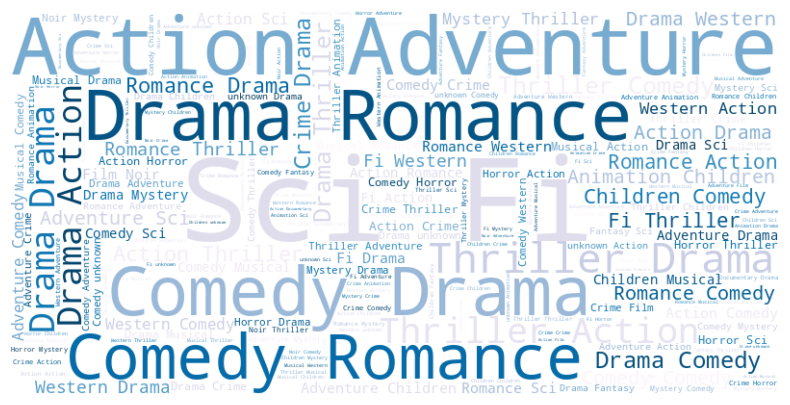

In [84]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that the most popular genra combinations include: drama and romance, action and adventure, comedy and romace, comedy and drama.

Dokończę